Evan Shoemaker  
12/13/2022    
Strava Running Data EDA  

### Introduction  
a. This domain is important to me because I wanted to find out if I have been improving my average mile times as I exercised over the past 6 months.  

b. The Strava data is in a CSV format. The weather data is originally in a JSON format but is converted to CSV for joining with the Strava DataFrame.  

c. Strava data comes as many Excel files. This ranges from email preferences to mobile device identifies to followers, and much more. The only table included in my dataset is "activities.csv". That dataset originally has 179 instances.

d. Attributes include activity ID, activity Date, activity Name, activity type, activity Description, elapsed time, distance, max heart rate, relative effort, elapsed time, moving time, max spped, average speed, elevation gain, elevation loss, elevation low, elevation high, max grade, and average grade.

e. I am trying to classify average speed over time.

f. Potential impacts of my results include creating/modifying a training plan for the future.

g. Stakeholders include me and Strava.

### Data Analysis  
a. I manually removed irrelevant columns from the dataset in Excel before using Pandas to remove instances of activities that weren't runs (bike rides) and trim the dataset to only be instances from the training period (May 2022 to November 2022).  

b. I merged the two tables (weather data and Strava data) by standardizing the date column and using and inner join to only match temperature dates to dates when I ran.

c. One challenge was date standardization. The Strava Data was in a non-standard American format and had a timestamp as well. The weather data was in a standard ISO format.

d. I collected data automatically through my phone and Apple Watch. My phone provided GPS data which speed could be extrapolated from.

e. I graphed average speed over time for the whole training period, as well as average speed over time and average daily temperature for the portion of the training period in Spokane (roughly half).

f. I am testing whether the later half of the data is faster than the earlier half and whether the average speed for days where the temperature ranges from 40 to 60 degrees F is faster than runs on days above 60 or below 40 degrees F.

### Load the Data:
Load uncleaned Strava data into DataFrame and clean it:

In [ ]:
import utils
import importlib
importlib.reload(utils) #alternative to restarting kernel every time

df, training_period = utils.load_clean_df("activities_trimmed.csv")

### The questions I want to answer:
Am I getting faster over time?
Does temperature impact my speed?

Let's test with visualization and hypothesis testing:

### Visualization (First Question):

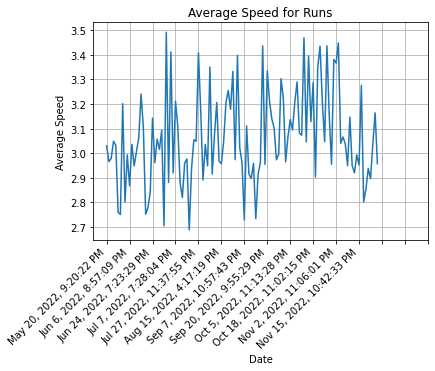

In [ ]:
dates = training_period.loc[:,"Activity Date"]
average_speeds = training_period.loc[:,"Average Speed"]

utils.graph_training_period(dates, average_speeds)

### Hypothesis Testing (First Question):

Judging off the plot, it isn't readily obvious that I'm getting faster throughout time. For hypothesis testing, I will divide the running data into two groups: the first (earlier) half of the data, and the second (later) half and will test if one group is faster than the other.

#### Step 1:  
$H_0:$ The later half of the data is not faster than the earlier half.  
$H_a:$ The later half of the data is faster than the earlier half.

#### Step 2:  
$\alpha = 0.01$

#### Step 3:  
The two halves of the data are independent. The appropriate formula is:  
$\frac{\overline {x_1} - \overline {x_2}}{\sqrt {s_p^2(\frac{1}{n_1} + \frac{1}{n_2})}}$ where $s_p^2 = \frac{(n_1-1)S_1^2 + (n_2 - 1)S_2^2}{n_1 + n_2 - 2}$

In [ ]:
first, second = utils.get_halves(training_period)
dF = len(first) + len(second) - 2
print(dF)

115


#### Step 4:  
There are 119 instances, so each group should be approximately 60 instances. $\alpha = 0.01$, df = 115,
$t_{critical} = 2.326$

In [ ]:
utils.t_test(second, first, 0.01)

1.9075479324274682 0.02947188412779394
DO NOT reject H0


#### Step 5.  
The pval is less than alpha, so we do not reject $H_0$. This means the second half of the data is not faster than the earlier half.

### Second Question: (Does the temperature impact my speed?)

For this question, I chose to look at only my Spokane data since I was in Seattle for the summer and the temperature there was pretty consistent over the whole summer. In Spokane, from the start of the school year until now the temperature varied significantly.

In [ ]:
from api_info import api_key, url

url = utils.format_city_url(url, api_key, "Spokane")
json_obj = utils.request_JSON_object(url)
latitude, longitude = utils.extract_latitude_and_longitude(json_obj)

url = utils.format_coordinate_url('https://meteostat.p.rapidapi.com/stations/nearby',latitude, longitude)
station_obj = utils.get_MeteoStat_object(url,'3d748e90a4mshb2303e21128ddd3p1be280jsn5b9012b3d41d')
nearest_station_id = utils.extract_weather_station_id(station_obj)

url = utils.format_id_url("https://meteostat.p.rapidapi.com/stations/daily", nearest_station_id, "2022-08-29","2022-11-28") #get only data for training period in Spokane
data_array = utils.get_MeteoStat_object(url, '3d748e90a4mshb2303e21128ddd3p1be280jsn5b9012b3d41d')
data = utils.format_daily_data(data_array)
daily_data_df = utils.create_weather_df("Spokane", data, ["date", "Average Temperature", "Min Temp", "Max Temp", "Precipitation", "Snow", "Wind Direction", "Wind Speed", "wpgt", "pres", "tsun"])
utils.clean_df("Spokane", daily_data_df)

Spokane_temps = daily_data_df["Average Temperature"] #average temperature for each Spokane day
daily_data_df.to_csv("Spokane_Weather.csv")
weather_dates = daily_data_df["date"]
strava_dates = df["Activity Date"]
daily_data_df, training_period = utils.standardize_dates(daily_data_df, training_period)

strava_and_temperature_data = utils.join_strava_and_temperature_data(daily_data_df, training_period)
strava_and_temperature_data.to_csv("strava_and_temperature_data.csv")

### Visualization:

<Figure size 432x288 with 0 Axes>

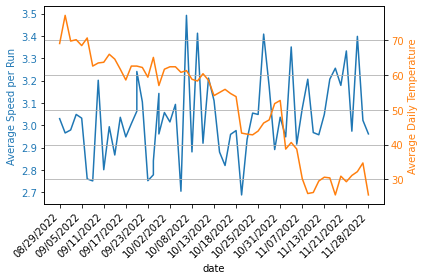

In [ ]:
utils.graph_speeds_and_temps(strava_and_temperature_data)

### Hypothesis testing (Second Question):

I felt at my fastest on days with moderate temperatures (40 to 60 F) and especially on rainy days in this temperature range, but we'll just focus on temperature. Days hotter or colder than this temperature range at least felt like they slowed me down.

#### Step 1.  
$H_0$: The average speed for days where the temperature ranges from 40 to 60 degrees F is not faster than runs on days above 60 or below 40.  
$H_a$: The average speed for days where the temperature ranges from 40 to 60 degrees F is faster than runs on days above 60 or below 40.

#### Step 2.  
$\alpha = 0.01$

#### Step 3.  
The ranges of data are independent. The appropriate formula is:  
$\frac{\overline {x_1} - \overline {x_2}}{\sqrt {s_p^2(\frac{1}{n_1} + \frac{1}{n_2})}}$ where $s_p^2 = \frac{(n_1-1)S_1^2 + (n_2 - 1)S_2^2}{n_1 + n_2 - 2}$

In [ ]:
below_forty_above_sixty, forty_to_sixty = utils.separate_df_by_temperature_ranges(strava_and_temperature_data)
below_forty_above_sixty_speeds = below_forty_above_sixty["Average Speed"]
forty_to_sixty_speeds = forty_to_sixty["Average Speed"]
dF = len(below_forty_above_sixty_speeds) + len(forty_to_sixty_speeds) - 2
print(dF)

58


#### Step 4:  
There are 60 instances. $\alpha = 0.01$, df = 58,
$t_{critical} = 2.390$

In [ ]:
utils.t_test(below_forty_above_sixty_speeds, forty_to_sixty_speeds, 0.01)

0.018366694870224794 0.49270467955267405
DO NOT reject H0


#### Step 5.

The pval is less than alpha, so we do not reject the null hypothesis. This means my average speed for runs during moderate temperature ranges is not significantly faster than runs in more extreme hot and cold temperatures.

### Classification Results  
a. I'm using average speed for each run as class information. For KNN, I created a categorical representation of speeds for each run: if it is above the average speed for all runs, it is "faster". If it is below the average speed for all runs, it is "slower".  
    i. 47% faster, 53% slower

b. I expect them to both be at least somewhat accurate (> 60%)

c. I'm comparing their accuracy scores.

d. Some challenges I faced were dsicovering what caused my KNN to have 100% accuracy (seems unlikely).


### Classification:  

In [ ]:
global_average_speed = strava_and_temperature_data["Average Speed"].mean() #average speed of all runs from training period

For KNN, we will create a categorical representation of speeds for each run: if it is above the average speed for all runs, it is "faster". If it is below the average speed for all runs, it is "slower".

In [ ]:
strava_and_temperature_data = utils.create_categorical_speed_ranking(strava_and_temperature_data, global_average_speed)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import numpy as np

LabelEncoder = preprocessing.LabelEncoder()
clf = DecisionTreeClassifier(max_depth = 3)

strava_and_temperature_data.replace(np.NaN, 0, inplace=True)

date = LabelEncoder.fit(strava_and_temperature_data.loc[:, "date"])
date = LabelEncoder.transform(strava_and_temperature_data.loc[:, "date"])
strava_and_temperature_data.loc[:, "date"] = date

ActivityName = LabelEncoder.fit(strava_and_temperature_data.loc[:, "Activity Name"])
ActivityName = LabelEncoder.transform(strava_and_temperature_data.loc[:, "Activity Name"])
strava_and_temperature_data.loc[:, "Activity Name"] = ActivityName

ActivityType = LabelEncoder.fit(strava_and_temperature_data.loc[:, "Activity Type"])
ActivityType = LabelEncoder.transform(strava_and_temperature_data.loc[:, "Activity Type"])
strava_and_temperature_data.loc[:, "Activity Type"] = ActivityType

#drop columns related to speed/distance that would allow classifiers to "cheat"
strava_and_temperature_data.drop("Max Speed", axis=1, inplace=True)
strava_and_temperature_data.drop("Average Speed", axis=1, inplace=True)
strava_and_temperature_data.drop("Distance", axis=1, inplace=True)

faster_or_slower = strava_and_temperature_data["Faster or Slower"]
strava_and_temperature_data.drop("Faster or Slower", axis=1, inplace=True)
clf.fit(strava_and_temperature_data, faster_or_slower)
acc = clf.score(strava_and_temperature_data, faster_or_slower)
print("Accuracy: ", acc)

Accuracy:  0.95


In [ ]:
faster_percentage, slower_percentage = utils.calculate_percentage_faster_or_slower(faster_or_slower)
print("Faster percentage: ", faster_percentage)
print("Slower percentage: ", slower_percentage)

Faster percentage:  0.4666666666666667
Slower percentage:  0.5333333333333333


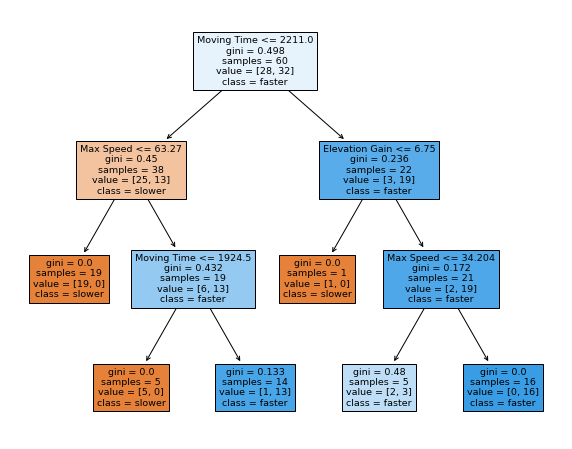

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
tree.plot_tree(clf, feature_names=df.columns, class_names={1:"faster", 0:"slower"}, filled=True)
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(strava_and_temperature_data, faster_or_slower, random_state=0, stratify=faster_or_slower)

scaler = MinMaxScaler()
scaler.fit(X_train)
train_normalized = scaler.transform(X_train)
test_normalized = scaler.transform(X_test)

knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(train_normalized, y_train)
faster_or_slower_predicted = knn_clf.predict(test_normalized)
acc = knn_clf.score(test_normalized, faster_or_slower_predicted)
print("Accuracy: ", acc)

clf = DecisionTreeClassifier(max_depth = 3)
clf.fit(train_normalized, y_train)
faster_or_slower_predicted = clf.predict(test_normalized)
acc = knn_clf.score(test_normalized, faster_or_slower_predicted)
print("Accuracy: ", acc)


Accuracy:  1.0
Accuracy:  0.6


### Conclusion:  

a. I used my Strava running data from the past 6 months and MeteoStat weather date to get corresponding average temperature for each day.

b. I used KNN and decision tree classifiers to classify the "Faster or Slower" categorical attribute of my dataset.

c. This analysis could be of use for Strava as it implements more statistics for its paid subscription service. Users may be interested in how their temperature-adjusted effort compares across training periods. It takes more energy to run a 7:45 mile when it's 30 degrees out than when it's 60. Strava already calculates relative effort for its paid subscription service. This could be another feature. Ethically, calculating statistics on user's data without their strong and explicit consent (not just agreeing to "Terms and Conditions", especially without actually having to read them) is ethically questionable at best.